# Tutorial for training and testing NN-NMR model

Using P2-type Na<sub>2/3</sub>(Mg<sub>1/3</sub>Mn<sub>2/3</sub>)O<sub>2</sub> as an example, 1000 configurations extracted from two 200ns DPMD trajectories of *P*6<sub>3</sub>/*mcm* and *P*6<sub>3</sub>22 supercell models, 16000 <sup>23</sup>Na shifts.


## Pre-requirement

PyTorch environment setup on Bohrium image.

## Install

The version of Tensorflow is depended by CUDA

In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 20.6 MB 10.3 MB/s eta 0:00:01
     |████████████████████████████████| 9.3 MB 4.5 MB/s eta 0:00:011
     |████████████████████████████████| 11.3 MB 6.0 MB/s eta 0:00:01     |█████████████████████████████▌  | 10.4 MB 6.0 MB/s eta 0:00:01
     |████████████████████████████████| 26.7 MB 3.5 MB/s eta 0:00:011
^C
ERROR: Operation cancelled by user


## Library and Environment

In [1]:
# Importing libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from ase.io import read
from nn_nmr import get_df_from_outcars

## From OUTCAR to SOAP descriptors and chemical shifts

- input: 
    - OUTCAR
    - expression
    - elements


- output: 
    - DataFrame(X: soaps, y: FCShifts)

In [2]:
# Defining SOAP parameters
expression = "soap cutoff=5.5 cutoff_transition_width=0.5 n_max=9 l_max=9 atom_sigma=0.55 n_Z=1 n_species=4 species_Z={11, 12, 25, 8}"
elements = ['Na']

# Getting data from many OUTCARs
folders = ['./p63mcm/', './p6322/']
df_all = pd.DataFrame()
for foldername in folders:
    outcar_list = os.listdir(foldername)
    outcar_list.sort(key=lambda x: int(x.lstrip('OUTCAR')))
    df_tmp = get_df_from_outcars([os.path.join(foldername, outcar) for outcar in outcar_list], expression=expression, elements=elements)
    df_all = pd.concat([df_all, df_tmp])
df_all

,X,y
0,"[0.06860095117868371, 1.4376865277355852e-08, ...",707.345735
1,"[0.06039654417031627, 1.213281348026635e-08, 1...",2132.439348
2,"[0.06803802894283517, 3.425563452549015e-08, 2...",1019.410030
3,"[0.0601215233161849, 3.0016900889318795e-08, 5...",2206.854680
4,"[0.0698653952573221, 6.271954105804142e-09, 2....",488.900729
...,...,...
7995,"[0.06059652226968545, 1.107213164013808e-08, 1...",2754.167443
7996,"[0.06273516264810623, 7.466261630613156e-08, 3...",2146.042151
7997,"[0.0598401274934071, 3.556574835201933e-08, 3....",2384.491279
7998,"[0.060939281084748026, 5.2898791951485635e-08,...",1899.591374


## Training and testing the NN-NMR model

- input: 
    - data(DataFrame)


- output files stored in '{WORKDIR}/results/': 
    - model: stored in 'model_test'
    - test set information after training: stored in 'rmse_and_test_data.npy'. key-'test_y' shows chemical shifts of training set; key-'test_y_pred' shows predicted values of chemical shifts corresponding to the key-'test_y'; key-'rmse' shows the value of rmse between key-'test_y' and key-'test_y_pred'
    - training history: stored in 'model_test_hist.pkl'

In [3]:
def get_Xy_from_df(df):
    X, y = np.array(df['X'].to_list()), df['y'].values
    return X, y

In [4]:
# Training the NN-NMR model
X, y = get_Xy_from_df(df_all) # get X and y data from sampled data

In [5]:
X.shape, y.shape

((16000, 6660), (16000,))

In [6]:
import torch
from torch import nn
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

In [8]:
tensor_x = torch.Tensor(X)
tensor_y = torch.Tensor(y)
tensor_y = tensor_y.unsqueeze(1)
nmr_data = TensorDataset(tensor_x,tensor_y)

In [9]:
train_size = int(0.6 * len(nmr_data))
test_size = int(0.2 * len(nmr_data))
val_size = len(nmr_data) - train_size - test_size
train_data, test_data, val_data = random_split(
    nmr_data, [train_size, test_size, val_size], 
    generator=torch.Generator().manual_seed(114514)
)

In [10]:
# Have a look at size of training and test set.
train_size, test_size, val_size

(9600, 3200, 3200)

In [11]:
batch_size = 1024
train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [12]:
for X, y in test_dataloader:
    print(f"Shape of X [N, C]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C]: torch.Size([1024, 6660])
Shape of y: torch.Size([1024, 1]) torch.float32


In [38]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.BatchNorm1d(len(test_dataloader.dataset[0][0])),
            nn.Linear(len(test_dataloader.dataset[0][0]), 256),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): BatchNorm1d(6660, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=6660, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=256, out_features=256, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.2, inplace=False)
    (10): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [39]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        return loss.item()

In [40]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    return test_loss

In [41]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-4)
#scheduler = StepLR(optimizer, step_size=10000)

In [ ]:
epochs = 4000
loss_train = []
loss_test = []
for t in tqdm(range(epochs)):
    ltrn = train(train_dataloader, model, loss_fn, optimizer)
    ltst = test(test_dataloader, model, loss_fn)
    loss_train.append(ltrn)
    loss_test.append(ltst)
    scheduler.step()
    if t % 100 == 0:
        print(ltrn, ltst)

  0%|          | 2/4000 [00:00<05:08, 12.95it/s]

3284588.5 3226814.0625


  3%|▎         | 102/4000 [00:08<05:17, 12.28it/s]

100930.796875 243724.52734375


  5%|▌         | 202/4000 [00:16<05:08, 12.33it/s]

62232.3515625 57346.84765625


  8%|▊         | 302/4000 [00:24<05:19, 11.56it/s]

39475.35546875 32582.47607421875


 10%|▉         | 384/4000 [00:31<04:56, 12.18it/s]

In [84]:
import matplotlib.pyplot as plt

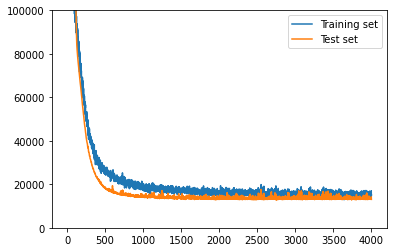

In [43]:
ax = plt.subplot()
ax.plot(loss_train, label="Training set")
ax.plot(loss_test, label="Test set")
ax.set_ylim(0, 100000)
ax.legend()

In [44]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [45]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

## Predict

- input:
    - model
    - atoms
    - expression
    - elements


- output:
    - chemical shifts


The script for generating chemical shifts in batches on HPC is shown in 'gpu.py' and 'gpu.lsf'

In [46]:
validation_loader = DataLoader(val_data)
#test_data.dataset.tensors[0].size(), test_data.dataset.tensors[1].size()

In [47]:
test_dict = {
    "test_y": [],
    "test_y_pred": []
}
for X, y in validation_loader:
    #print(X, y)
    test_dict['test_y'].append(float(y))
    #X, y = X.to(device), y.to(device)
    model.eval()
    pred = model(X)
    test_dict['test_y_pred'].append(float(pred))

In [48]:
from sklearn.metrics import mean_squared_error

RMSE: 116.48295566919805
R^2: 0.9652708128419565


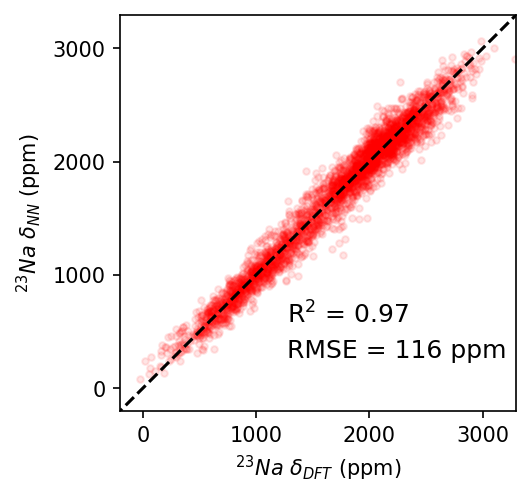

In [49]:
# RMSE and R2
rmse_test = np.sqrt(mean_squared_error(test_dict['test_y'], test_dict['test_y_pred']))
print(f'RMSE: {rmse_test}')
R2 = r2_score(test_dict['test_y'], test_dict['test_y_pred'])
print(f'R^2: {R2}')

# Plotting the correlation of 23Na shift calculated with DFT and with NN-NMR model
fig, ax = plt.subplots(figsize=(3.5, 3.5), dpi=150)
ax.scatter(test_dict['test_y'], test_dict['test_y_pred'], alpha=0.1, s=10, c='r')

ax.text(min(test_dict['test_y'])+1300, min(test_dict['test_y'])+300, "RMSE = " + "%.0f"%(rmse_test)+' ppm', fontsize = 12)
ax.text(min(test_dict['test_y'])+1300, min(test_dict['test_y'])+600, "R$^{2}$ = " + "%.2f"%(R2), fontsize = 12)

ax.set_xlabel('$^{23}Na$ $\delta_{DFT}$ (ppm)')
ax.set_ylabel('$^{23}Na$ $\delta_{NN}$ (ppm)')
ax.axis('equal')
ax.axis('square')   
plt.xticks(np.arange(0,3500,1000))
plt.yticks(np.arange(0,3500,1000))
plt.xlim([-200,3300])
plt.ylim([-200,3300])
_ = ax.plot([-10000, 10000], [-10000, 10000], c='k', ls='--')

#plt.savefig(foldername+'correlation.jpg', dpi = 400, bbox_inches = 'tight')

In [50]:
from nn_nmr import get_soaps_from_atoms

In [51]:
test_atoms = read('predict_fcshifts_example.xyz')
soaps = get_soaps_from_atoms(test_atoms, expression=expression, elements=elements)

In [52]:
with torch.no_grad():
    tx = torch.Tensor(soaps)
    pred = model(tx)
    print(f'Predicted: "{pred}"')

Predicted: "tensor([[2150.4160],
        [1926.4062],
        [ 612.2258],
        [2113.6824],
        [1989.7628],
        [2355.6655],
        [2490.8630],
        [ 968.2466],
        [1055.8987],
        [ 810.4955],
        [ 535.9751],
        [2728.0090],
        [1414.2411],
        [2247.1450],
        [1980.5605],
        [2260.7917]])"
